In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import julia
import os
from concurrent.futures import ThreadPoolExecutor

In [2]:
#julia.install()

In [3]:
base_path = r"D:\ncbi_dataset\ncbi_dataset\data\vafs\{}.vaf"
path = r"D:\ncbi_dataset\ncbi_dataset\data\vafs\m_Netherlands_2020-3_671.vaf"

In [4]:
def read_vaf(path):
    with open(path, "r") as f:
        return np.array(list(map(lambda l:float(l), f.readlines())))

In [5]:
def write_vafs(path, array):
    if os.path.exists(path):
        raise FileExistsError("VAF file exists already")
    with open(path, "w") as f:
        f.write("\n".join(map(lambda n:str(n), array)))

In [5]:
netherlands2003 = read_vaf(base_path.format("m_Netherlands_2020-3_671"))
usa2111 = read_vaf(base_path.format("m_USA_2021-11_89440"))
slovakia = read_vaf(base_path.format("m_Slovakia_2021-11_1498"))

In [8]:
netherlands_filtered = netherlands2003[netherlands2003 >= 0.01]
usa_filtered = usa2111[usa2111 >= 0.01]
slovakia_filtered = slovakia[slovakia >= 0.01]
#filtered = filtered[filtered<1.0]

---

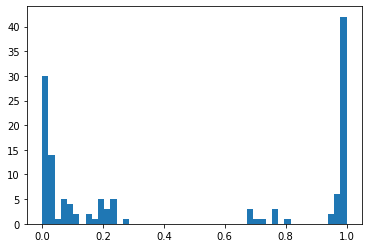

In [9]:
plt.hist(netherlands_filtered, bins=np.linspace(0,1,50))
print()

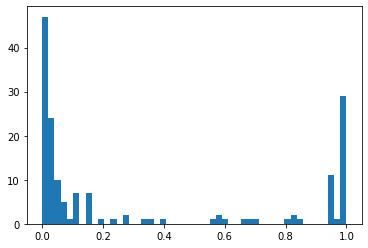

In [10]:
plt.hist(usa_filtered, bins=np.linspace(0,1,50))
print()

In [7]:
Minvaf = 0.01
Nmax = 2000

In [10]:
def prepare_file(filename):
    if f"filtered{Minvaf}" in filename:
        filtered_filename = ".".join(filename.split(".")[:-1])
        read_depth = int(filtered_filename.split("_")[-2])
        filtered_vafs = read_vaf(base_path.format(filtered_filename))
        n_mutations = len(filtered_vafs)
    elif "filtered" in filename: # sort out files which are filtered, but with different threshold
        return
    else: 
        base_name = ".".join(filename.split(".")[:-1])
        read_depth = int(base_name.split("_")[-1])
        vafs = read_vaf(base_path.format(base_name))
        filtered_vafs = vafs[vafs>=Minvaf]
        n_mutations = len(filtered_vafs)
        filtered_filename = f"{base_name}_{n_mutations}-filtered{Minvaf}"
    if not os.path.exists(base_path.format(filtered_filename)):
        write_vafs(base_path.format(filtered_filename), filtered_vafs)
    if n_mutations >= 100 and not os.path.exists(f"D:/ncbi_dataset/ncbi_dataset/data/ABC_results/{filtered_filename}_Nmax{Nmax}"):
        do_ABC(filtered_filename, read_depth, minvaf = Minvaf, Nmax = Nmax)

In [11]:
def do_ABC(input_file, read_depth, minvaf = 0.01, Nmax = 2000, birth_rate = np.log(3)): # nparticles = 500, d = 0
    function_call = f"fitABCmodels(\\\"D:/ncbi_dataset/ncbi_dataset/data/vafs/{input_file}.vaf\\\", \\\"{input_file}_Nmax{Nmax}_b-log({np.exp(birth_rate):.1f})\\\", read_depth = {read_depth}, minvaf = {minvaf}, fmax = 1.0, maxiterations = 2*10^5, Nmax = {Nmax}, resultsdirectory = \\\"D:/ncbi_dataset/ncbi_dataset/data/ABC_results\\\", progress = true, verbose = true, save = true, Nmaxinf = 10^6, ploidy = 1, b = {birth_rate}, convergence = 0.005, mincellularity = 0.95, maxcellularity = 1.05)"
    statements = ["using SubClonalSelection", "using Random", "Random.seed!(123)", function_call]
    call = f'julia -J "C:\\Users\Konrad Grudzinski\\OneDrive - University of Glasgow\\Computing\\4th Year\\Individual Project\\Source\\covid19\\SubClonalSelection\\sysimage_runabc.so" -e "{"; ".join(statements)}"'
    returncode = os.system(f'start /wait cmd /c {call}')
    if returncode != 0:
        print(returncode, input_file)

In [35]:
files = os.listdir("D:/ncbi_dataset/ncbi_dataset/data/vafs")
with ThreadPoolExecutor(max_workers = 6) as executor:
    threads = executor.map(prepare_file, files)

In [60]:
os.listdir("D:/ncbi_dataset/ncbi_dataset/data/vafs")

['m_Argentina_2020-6_20.vaf',
 'm_Argentina_2020-9_15.vaf',
 'm_Australia_2020-10_22.vaf',
 'm_Australia_2020-1_334.vaf',
 'm_Australia_2020-2_4.vaf',
 'm_Australia_2020-3_366.vaf',
 'm_Australia_2020-4_156.vaf',
 'm_Australia_2020-5_25.vaf',
 'm_Australia_2020-6_463.vaf',
 'm_Australia_2020-7_5105.vaf',
 'm_Australia_2020-8_2930.vaf',
 'm_Australia_2020-9_482.vaf',
 'm_Austria_2021-11_5.vaf',
 'm_Austria_2021-12_5.vaf',
 'm_Austria_2021-2_50.vaf',
 'm_Austria_2021-3_66.vaf',
 'm_Austria_2021-4_17.vaf',
 'm_Austria_2021-5_20.vaf',
 'm_Bahrain_2020-10_58.vaf',
 'm_Bahrain_2020-11_42.vaf',
 'm_Bahrain_2020-12_4.vaf',
 'm_Bahrain_2020-6_13.vaf',
 'm_Bahrain_2020-7_5.vaf',
 'm_Bahrain_2020-8_6.vaf',
 'm_Bahrain_2020-9_8.vaf',
 'm_Bahrain_2021-11_112.vaf',
 'm_Bahrain_2021-12_213.vaf',
 'm_Bahrain_2021-1_6.vaf',
 'm_Bahrain_2021-2_19.vaf',
 'm_Bahrain_2021-3_5.vaf',
 'm_Bahrain_2021-4_16.vaf',
 'm_Bahrain_2021-5_19.vaf',
 'm_Bahrain_2021-6_7.vaf',
 'm_Bahrain_2021-7_9.vaf',
 'm_Bahrain_2021

In [17]:
prepare_file("m_Slovakia_2021-11_1498.vaf")

In [ ]:
    SubClonalSelection.fitABCmodels(
      f"D:/ncbi_dataset/ncbi_dataset/data/vafs/{input_file}.vaf",
      "{input_file}_Nmax{Nmax}",
      read_depth = read_depth,        # that's basically in the filename, can read the VCF again
      minvaf = minvaf,           # should do something here, like at least n/500, to filter VAFs of 1/n. OVERRIDES minreads and fmin!!
      fmax = 1.0,            # Maybe set to 1? Could be that mutation becomes dominant after some time
      maxiterations = 10**5, # probably 1000 is enough
      maxclones = 2,          # leave this, want to check all possibilities
      nparticles = 500,       # we are dealing with smaller samples in general
      Nmax = Nmax,            # Maximum population size used to fit data, adapt to read depth and Nmaxinf 
      resultsdirectory = "D:/ncbi_dataset/ncbi_dataset/data/ABC_results",
      progress = False,        # launch terminal to show progress?
      verbose = False,
      save = True,
      Nmaxinf = 10**6,         # Maybe adapt to actual samples size, together with max iterations? Probably better to leave it, realistic for most smaller countries
      ploidy = 1,             # Virus is monoploid
      b = birth_rate,             # According to https://pubmed.ncbi.nlm.nih.gov/32498136/, R0 is 1.9-6.7, median of 3.38 (=> basic reproduction number). 
      savepopulations = False,
      convergence = 0.005,
      #mincellularity = 1.0     # cellularity of the subclone, so all of the RNA is virus, but the "cellularity" is the fraction of the subclone, has to be <1
      )
    return
    ###########################

---

Run ABC on specific files with specialised parameters

In [8]:
def prepare_file_b(filename, birth_rate, minVAF = Minvaf):
    if f"filtered{minVAF}" in filename:
        filtered_filename = ".".join(filename.split(".")[:-1])
        read_depth = int(filtered_filename.split("_")[-2])
        filtered_vafs = read_vaf(base_path.format(filtered_filename))
        n_mutations = len(filtered_vafs)
    elif "filtered" in filename: # sort out files which are filtered, but with different threshold
        return
    else: 
        base_name = ".".join(filename.split(".")[:-1])
        read_depth = int(base_name.split("_")[-1])
        vafs = read_vaf(base_path.format(base_name))
        filtered_vafs = vafs[vafs>=minVAF]
        n_mutations = len(filtered_vafs)
        filtered_filename = f"{base_name}_{n_mutations}-filtered{minVAF}"
    if not os.path.exists(base_path.format(filtered_filename)):
        write_vafs(base_path.format(filtered_filename), filtered_vafs)
    if n_mutations >= 100 and not os.path.exists(f"D:/ncbi_dataset/ncbi_dataset/data/ABC_results/{filtered_filename}_Nmax{Nmax}_b-log({np.exp(birth_rate):.1f})"):
        do_ABC(filtered_filename, read_depth, minvaf = minVAF, Nmax = Nmax, birth_rate = birth_rate)

In [41]:
files = [
    # alpha
    'm_United-Kingdom_2021-1_42335_150-filtered0.01.vaf',
    'm_United-Kingdom_2021-2_19586_150-filtered0.01.vaf',
    'm_United-Kingdom_2021-3_722_187-filtered0.01.vaf',
    'm_United-Kingdom_2021-4_1090_231-filtered0.01.vaf',
    # delta
    'm_United-Kingdom_2021-5_3445_240-filtered0.01.vaf',
    'm_United-Kingdom_2021-6_4438_131-filtered0.01.vaf',
    'm_United-Kingdom_2021-7_6862_101-filtered0.01.vaf',
    'm_United-Kingdom_2021-9_4463_115-filtered0.01.vaf',
    'm_United-Kingdom_2021-10_4817_151-filtered0.01.vaf',
    'm_United-Kingdom_2021-11_3674_167-filtered0.01.vaf'
]
birth_rates = np.log([
    # alpha
    4.5,
    4.5,
    4.5,
    4.5,
    # delta
    7,
    7,
    7,
    7,
    7,
    7
])
with ThreadPoolExecutor(max_workers = 6) as executor:
    threads = executor.map(prepare_file_b, files, birth_rates)

In [13]:
files = [
    'm_United-Kingdom_2020-6_4774_115-filtered0.01.vaf',
    'm_United-Kingdom_2020-7_2157_154-filtered0.01.vaf',
    # EU1
    'm_United-Kingdom_2020-8_5185_223-filtered0.01.vaf',
    'm_United-Kingdom_2020-9_9567_233-filtered0.01.vaf',
    'm_United-Kingdom_2020-10_16288_200-filtered0.01.vaf',
    'm_United-Kingdom_2020-11_20799_237-filtered0.01.vaf',
    # alpha
    'm_United-Kingdom_2020-12_20282_141-filtered0.01.vaf',
    'm_United-Kingdom_2021-1_42335_150-filtered0.01.vaf',
    'm_United-Kingdom_2021-2_19586_150-filtered0.01.vaf',
    'm_United-Kingdom_2021-3_722_187-filtered0.01.vaf',
    'm_United-Kingdom_2021-4_1090_231-filtered0.01.vaf',
    # delta
    'm_United-Kingdom_2021-5_3445_240-filtered0.01.vaf',
    'm_United-Kingdom_2021-6_4438_131-filtered0.01.vaf',
    'm_United-Kingdom_2021-7_6862_101-filtered0.01.vaf',
    'm_United-Kingdom_2021-9_4463_115-filtered0.01.vaf',
    'm_United-Kingdom_2021-10_4817_151-filtered0.01.vaf',
    'm_United-Kingdom_2021-11_3674_167-filtered0.01.vaf'
]
birth_rates = np.log([
    0.8,
    0.8,
    # EU1
    0.9,
    1.1,
    1.4,
    1.1,
    # alpha
    1.0,
    1.1,
    0.8,
    0.8,
    0.9,
    # delta
    0.9,
    1.2,
    1.3,
    1.0,
    1.0,
    1.0
])
with ThreadPoolExecutor(max_workers = 6) as executor:
    threads = executor.map(prepare_file_b, files, birth_rates)